[1.111059153612345, 0.9144298324626196, 1.1529770992366413, 0.8875168387965873, 1.542763157894737, 0.27631578947368424, 7.980769230769231, 0.22435897435897437, 0.5926829268292683, 1.3973825104104698, 1.568593910366062, 0.7761917586856989, 2.0868571428571427, 0.2075, 4.715447154471544, 0.5871725383920505, 0.3583959899749374, 5.063492063492064, 1.0092537313432837, 0.99523003539006]
{0: {0: 0.45728643216080395, 1: 0.542713567839196}, 1: {0: 0.45309905921416715, 1: 0.5469009407858328}, 2: {0: 0.8283378746594005, 1: 0.17166212534059944}, 3: {0: 0.33121019108280253, 1: 0.6687898089171974}, 4: {0: 0.36637768563889933, 1: 0.6336223143611006}, 5: {0: 0.33647979739841144, 1: 0.6635202026015885}, 6: {0: 0.7784697508896797, 1: 0.22153024911032027}, 7: {0: 0.1591203104786546, 1: 0.8408796895213454}, 8: {0: 0.6941747572815534, 1: 0.3058252427184466}, 9: {0: 0.34121002240782233, 1: 0.6587899775921776}}
MDP with 10 states and 2 actions
discounting factor gamma = 0.95

The Policy is
(0,0) = 0.457286432

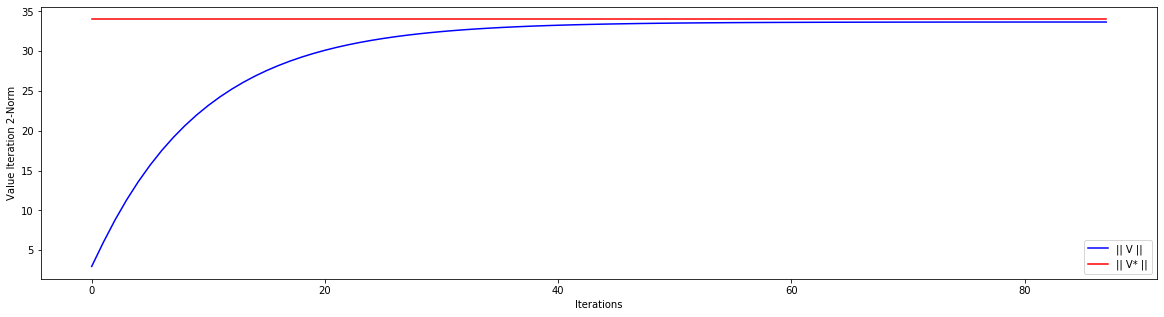

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox.example
import math


class ValueIterator:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, behavior_policy , target_policy, states, actions, gamma=0.95, theta= 0.0001, rho_bar=1):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.V = np.zeros(states)

        #discount rate between [0,1]
        self.gamma = gamma

        #the amount of states and actions
        self.states = states
        self.actions = actions
        
        #mapping from states to actions
        self.target_policy = target_policy
        self.behavior_policy = behavior_policy
        
        #Transition Probability and Reward Shape: AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        #reward matrix
        self.rewardMatrix = np.random.rand(actions,states, states)
        
        #theta stopping threshold on when to stop running value iteration
        self.theta = theta

        #save the values to plot later
        self.plot = []
        
        #amount of iterations that occurred
        self.iterations = 0
        
        
        #rho truncated weight to use
        self.rho_bar = rho_bar
        
        
        self.policy_rho = {}
        
        
    def setRewardMatrix(self,matrix):
        """
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        :param: matrix: reward matrix 
        """
        self.rewardMatrix = matrix
        
    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]



    def getValueVector(self):
        """
        for the ability to plot the value function getting the values of all the states as a vector
        return: a list of all the values
        """
        values = []
        for state in range(self.states):
            values.append(self.value_function[state])
        return np.array(values)
    
    
    def policyUnderRho(self):
        """
        Calculate the policy under rho
        :return: policy based on rho
        """
        
        print([self.target_policy[s][a]/self.behavior_policy[s][a] for s in range(self.states) for a in range(self.actions)])
        for s in range(self.states):
            summation = 0
            s_dict = {}
            for a in range(self.actions):
                summation+= min(self.rho_bar*(self.behavior_policy[s][a]), self.target_policy[s][a])
                
            for a in range(self.actions):
                s_dict[a] = min(self.rho_bar*(self.behavior_policy[s][a]), self.target_policy[s][a])/summation
                
            self.policy_rho[s] = s_dict
            
        
        return self.policy_rho

    def bellmanUpdate(self,state):
        """
        Carry Out the update for the Value Function
        param: state is the state that the iteration is currently working on
        return: a list of all the values each action calculates
        will be used later to find the policy as well
        """
        
        total = 0
        new_total = 0
        for a in range(self.actions):
            total=0
            for s_prime in range(self.states):
                total+= self.transitionProbabilities[a][state][s_prime]*(self.rewardMatrix[a][state][s_prime]+self.gamma*self.V[s_prime])
            new_total+= self.policy_rho[state][a]*total
            
        return new_total
    
    
    def valueIteration(self):
        """
        Perform Value Iteration on the given MDP 
        
        will provide a optimal deterministic policy for this MDP
        will Plot the V(s) function as well 
        """
        
        delta = float("inf")
        self.policyUnderRho()
        
        #value iteration
        while(delta > self.theta):
            delta = 0
            for s in range(self.states):
                v = self.V.copy()
                
                #bellman update
                self.V[s] = np.max(self.bellmanUpdate(s))
    
                delta = max(delta, abs(self.V[s]-v[s]))
            
            norm = np.linalg.norm(self.V)
            self.norm.append(norm)
            self.iterations+=1
        
    
    
    def plot(self):
        #Plotting the Difference between the limit of the Value Function and the value function each iteration
        #The Value function limit seems to be a Value Function with a 2-norm approaching around 16
        
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}\n")

        
        #print the policy
        print("The Policy is")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.policy_rho[s][a]}  ",end=" ")
            print()
                      
        
        print("\nNumber of Iterations to achieve a Value Function:   ", self.iterations)
        print("\nValue Function:  ", self.V, np.linalg.norm(self.V))
        
        #plot the value iteration plot
        plt.figure(figsize = (20,5))
        plt.plot(range(self.iterations), self.norm, "b-", label = "|| V ||")
        plt.plot(range(self.iterations),np.zeros(self.iterations)+math.ceil(self.norm[-1]),"r-", label = "|| V* ||")
        plt.xlabel("Iterations")
        plt.ylabel("Value Iteration 2-Norm")
        plt.legend()
        plt.show()
        
  

if __name__ == '__main__':
    
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """

    np.random.seed(0)
    states = 10
    actions = 2
    rho_bar = 1

    target_policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}
    behavior_policy = {0: {0: 0.4351851851851852, 1: 0.5648148148148148}, 1: {0: 0.423728813559322, 1: 0.576271186440678}, 2: {0: 0.5714285714285714, 1: 0.42857142857142855}, 3: {0: 0.1, 1: 0.9}, 4: {0: 0.49382716049382713, 1: 0.5061728395061729}, 5: {0: 0.2824427480916031, 1: 0.7175572519083969}, 6: {0: 0.42168674698795183, 1: 0.5783132530120482}, 7: {0: 0.1, 1: 0.9}, 8: {0: 0.8636363636363636, 1: 0.13636363636363635}, 9: {0: 0.3401360544217687, 1: 0.6598639455782312}}
    
    learner = ValueIterator(target_policy = target_policy,behavior_policy = behavior_policy, states = states, actions = actions, theta = 0.0001, rho_bar = rho_bar)
    learner.valueIteration()
    learner.plot()
    


